In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import os
import time
import PIL.Image as Image 
import matplotlib.pyplot as plt

In [8]:
# import all images from ../data-tumour/training 

yes_tumour_files = []
no_tumour_files = []

for filename in os.listdir('data-tumor/training/meningioma'):
    if filename.endswith(".jpg"):
        yes_tumour_files.append(filename)
for filename in os.listdir('data-tumor/training/notumor'):
    if filename.endswith(".jpg"):
        no_tumour_files.append(filename)


In [132]:
# create dataset
yes_tumour_images = []
no_tumour_images = []

for filename in yes_tumour_files:
    img = Image.open('data-tumor/training/meningioma/' + filename)
    img = img.resize((256, 256))
    img = img.convert('L')
    img = torch.tensor(np.array(img))
    img = img / 255
    yes_tumour_images.append(img)

for filename in no_tumour_files:
    img = Image.open('data-tumor/training/notumor/' + filename)
    img = img.resize((256, 256))
    img = img.convert('L')
    img = torch.tensor(np.array(img))
    img = img / 255
    no_tumour_images.append(img)

# create labels

yes_tumour_labels = torch.ones(len(yes_tumour_images))
no_tumour_labels = torch.zeros(len(no_tumour_images))

# create dataset

images = yes_tumour_images + no_tumour_images
labels = torch.cat((yes_tumour_labels, no_tumour_labels))

dataset = list(zip(images, labels))

# shuffle dataset
random.shuffle(dataset)

In [133]:
# see sizes of images in the dataset
image_sizes = {}
for i in range(len(dataset)):
    if dataset[i][0].shape in image_sizes:
        image_sizes[dataset[i][0].shape] += 1
    else:
        image_sizes[dataset[i][0].shape] = 1

In [134]:
print(image_sizes)

{torch.Size([256, 256]): 2934}


In [135]:
kernel_size = 5
padding_dimension = (kernel_size - 1) // 2
print(padding_dimension)

2


In [136]:
# add zero padding to the images
for i in range(len(dataset)):
    dataset[i] = (F.pad(dataset[i][0], (padding_dimension, padding_dimension, padding_dimension, padding_dimension)), dataset[i][1])

print(dataset[0][0].shape)

torch.Size([260, 260])


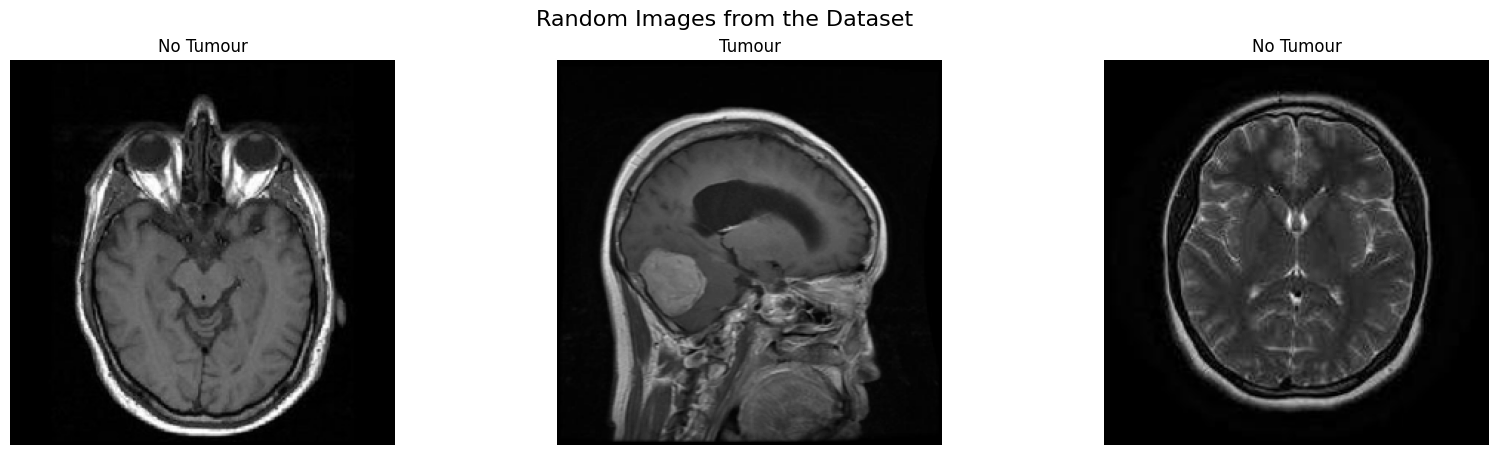

torch.Size([260, 260])
torch.Size([260, 260])
torch.Size([260, 260])


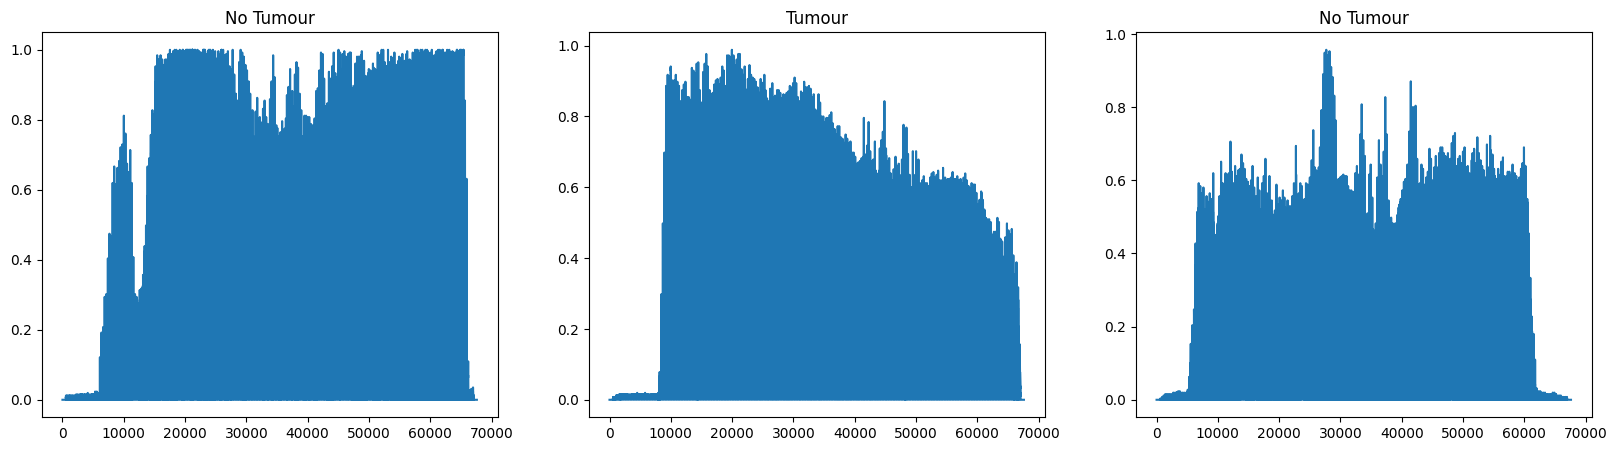

In [139]:
# display 5 random images from the dataset
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Random Images from the Dataset\n', fontsize=16)
choices = random.sample(range(len(dataset)), 3)
for i in range(3):
    img, label = dataset[choices[i]]
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title("Tumour" if label == 1 else "No Tumour")
    ax[i].axis('off')

plt.show()

fig.suptitle('Pixel Values of the Images\n', fontsize=16)
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i in range(3):
    img, label = dataset[choices[i]]
    print(img.shape)
    x = np.arange(0, img.shape[0] * img.shape[1])
    y = img.numpy().flatten()
    ax[i].plot(x, y)
    ax[i].set_title("Tumour" if label == 1 else "No Tumour")

plt.show()

In [109]:
# sp